In [1]:
# pip install google-adk

In [2]:
import credentials
import os

In [3]:
GOOGLE_API_KEY = credentials.GOOGLE_API_KEY
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [42]:
import uuid
from google.genai import types

from google.adk.agents import LlmAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService

from google.adk.tools.mcp_tool.mcp_toolset import McpToolset
from google.adk.tools.tool_context import ToolContext
from google.adk.tools.mcp_tool.mcp_session_manager import StdioConnectionParams
from mcp import StdioServerParameters

from google.adk.apps.app import App, ResumabilityConfig
from google.adk.tools.function_tool import FunctionTool

print("✅ ADK components imported successfully.")

✅ ADK components imported successfully.


In [19]:
retry_config = types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],  # Retry on these HTTP errors
)

## How MCP Works
MCP connects your agent (the client) to external MCP servers that provide tools:

* MCP Server: Provides specific tools (like image generation, database access)
* MCP Client: Your agent that uses those tools
All servers work the same way - standardized interface

### Architecture:
```
┌──────────────────┐
│   Your Agent     │
│   (MCP Client)   │
└────────┬─────────┘
         │
         │ Standard MCP Protocol
         │
    ┌────┴────┬────────┬────────┐
    │         │        │        │
    ▼         ▼        ▼        ▼
┌────────┐ ┌─────┐ ┌──────┐ ┌─────┐
│ GitHub │ │Slack│ │ Maps │ │ ... │
│ Server │ │ MCP │ │ MCP  │ │     │
└────────┘ └─────┘ └──────┘ └─────┘
```

**Step 1: Choose MCP Server**

For this demo, we'll use the Everything MCP Server - an npm package (@modelcontextprotocol/server-everything) designed for testing MCP integrations.

It provides a getTinyImage tool that returns a simple test image (16x16 pixels, Base64-encoded). Find more servers: modelcontextprotocol.io/examples

‼️ NOTE: This is a demo server to learn MCP. In production, you'll use servers for Google Maps, Slack, Discord, etc.

**Step 2: Create the MCP Toolset**

The McpToolset is used to integrate an ADK Agent with an MCP Server.

What the code does:

Uses npx (Node package runner) to run the MCP server
Connects to @modelcontextprotocol/server-everything
Filters to only use the getTinyImage tool (the server has others, but we only need this one)

In [21]:
# MCP integration with Everything Server
mcp_image_server = McpToolset(
    connection_params=StdioConnectionParams(
        server_params=StdioServerParameters(
            command="npx",  # Run MCP server via npx
            args=[
                "-y",  # Argument for npx to auto-confirm install
                "@modelcontextprotocol/server-everything",
            ],
            tool_filter=["getTinyImage"],
        ),
        timeout=30,
    )
)

print("✅ MCP Tool created")

✅ MCP Tool created


**Behind the scenes:**
* Server Launch: ADK runs npx -y @modelcontextprotocol/server-everything
* Handshake: Establishes stdio communication channel
* Tool Discovery: Server tells ADK: "I provide getTinyImage" functionality
* Integration: Tools appear in agent's tool list automatically
* Execution: When agent calls getTinyImage(), ADK forwards to MCP server
* Response: Server result is returned to agent seamlessly

Why This Matters: You get **instant access to tools without writing integration code**!

**Step 3: Add MCP tool to agent**

Let's add the mcp_server to the agent's tool array and update the agent's instructions to handle requests to generate tiny images.

In [22]:
# Create image agent with MCP integration
image_agent = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="image_agent",
    instruction="Use the MCP Tool to generate images for user queries",
    tools=[mcp_image_server],
)

In [23]:
from google.adk.runners import InMemoryRunner

runner = InMemoryRunner(agent=image_agent)

In [24]:
response = await runner.run_debug("Provide a sample tiny image", verbose=True)


 ### Created new session: debug_session_id

User > Provide a sample tiny image


/Users/nicooteiza/.pyenv/versions/agents/lib/python3.11/site-packages/google/adk/tools/mcp_tool/mcp_tool.py:103: UserWarning: [EXPERIMENTAL] BaseAuthenticatedTool: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  super().__init__(


image_agent > [Calling tool: getTinyImage({})]
image_agent > [Tool result: {'content': [{'type': 'text', 'text': 'This is a tiny image:'}, {'type': 'image', 'data': 'iVBORw0KG...]
image_agent > This is a tiny image:
The image above is the MCP tiny image.


In [30]:
from IPython.display import display, Image as IPImage
import base64

for event in response:
    if event.content and event.content.parts:
        for part in event.content.parts:
            if hasattr(part, "function_response") and part.function_response:
                for item in part.function_response.response.get("content", []):
                    if item.get("type") == "image":
                        display(IPImage(data=base64.b64decode(item["data"])))

# Extending to Other MCP Servers

**Kaggle MCP Server - For dataset and notebook operations**

*What it provides:*

- 📊 Search and download Kaggle datasets
- 📓 Access notebook metadata
- 🏆 Query competition information etc.,

In [31]:
McpToolset(
    connection_params=StdioConnectionParams(
        server_params=StdioServerParameters(
            command='npx',
            args=[
                '-y',
                'mcp-remote',
                'https://www.kaggle.com/mcp'
            ],
        ),
        timeout=30,
    )
)

# Long-Running Operations (Human-in-the-Loop)

Example: A shipping agent should ask for approval before placing a large order.

`User asks → Agent calls tool → Tool PAUSES and asks human → Human approves → Tool completes → Agent responds`

This is called a Long-Running Operation (LRO) - the tool needs to pause, wait for external input (human approval), then resume.

## What We're Building Today

Let's build a **shipping coordinator** agent with one tool that:

* Auto-approves small orders (≤5 containers)
* Pauses and asks for approval on large orders (>5 containers)
* Completes or cancels based on the approval decision

This demonstrates the core long-running operation pattern: `pause → wait for human input → resume`.

**The ToolContext Parameter**
Notice the function signature includes tool_context: `ToolContext`. ADK automatically provides this object when your tool runs. It gives you two key capabilities:

* Request approval: Call `tool_context.request_confirmation()`
* Check approval status: Read `tool_context.tool_confirmation`

In [33]:
LARGE_ORDER_THRESHOLD = 5


def place_shipping_order(
    num_containers: int, destination: str, tool_context: ToolContext
) -> dict:
    """Places a shipping order. Requires approval if ordering more than 5 containers (LARGE_ORDER_THRESHOLD).

    Args:
        num_containers: Number of containers to ship
        destination: Shipping destination

    Returns:
        Dictionary with order status
    """

    # -----------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------
    # SCENARIO 1: Small orders (≤5 containers) auto-approve
    if num_containers <= LARGE_ORDER_THRESHOLD:
        return {
            "status": "approved",
            "order_id": f"ORD-{num_containers}-AUTO",
            "num_containers": num_containers,
            "destination": destination,
            "message": f"Order auto-approved: {num_containers} containers to {destination}",
        }

    # -----------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------
    # SCENARIO 2: This is the first time this tool is called. Large orders need human approval - PAUSE here.
    if not tool_context.tool_confirmation:
        tool_context.request_confirmation(
            hint=f"⚠️ Large order: {num_containers} containers to {destination}. Do you want to approve?",
            payload={"num_containers": num_containers, "destination": destination},
        )
        return {  # This is sent to the Agent
            "status": "pending",
            "message": f"Order for {num_containers} containers requires approval",
        }

    # -----------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------
    # SCENARIO 3: The tool is called AGAIN and is now resuming. Handle approval response - RESUME here.
    if tool_context.tool_confirmation.confirmed:
        return {
            "status": "approved",
            "order_id": f"ORD-{num_containers}-HUMAN",
            "num_containers": num_containers,
            "destination": destination,
            "message": f"Order approved: {num_containers} containers to {destination}",
        }
    else:
        return {
            "status": "rejected",
            "message": f"Order rejected: {num_containers} containers to {destination}",
        }


print("✅ Long-running functions created!")

✅ Long-running functions created!


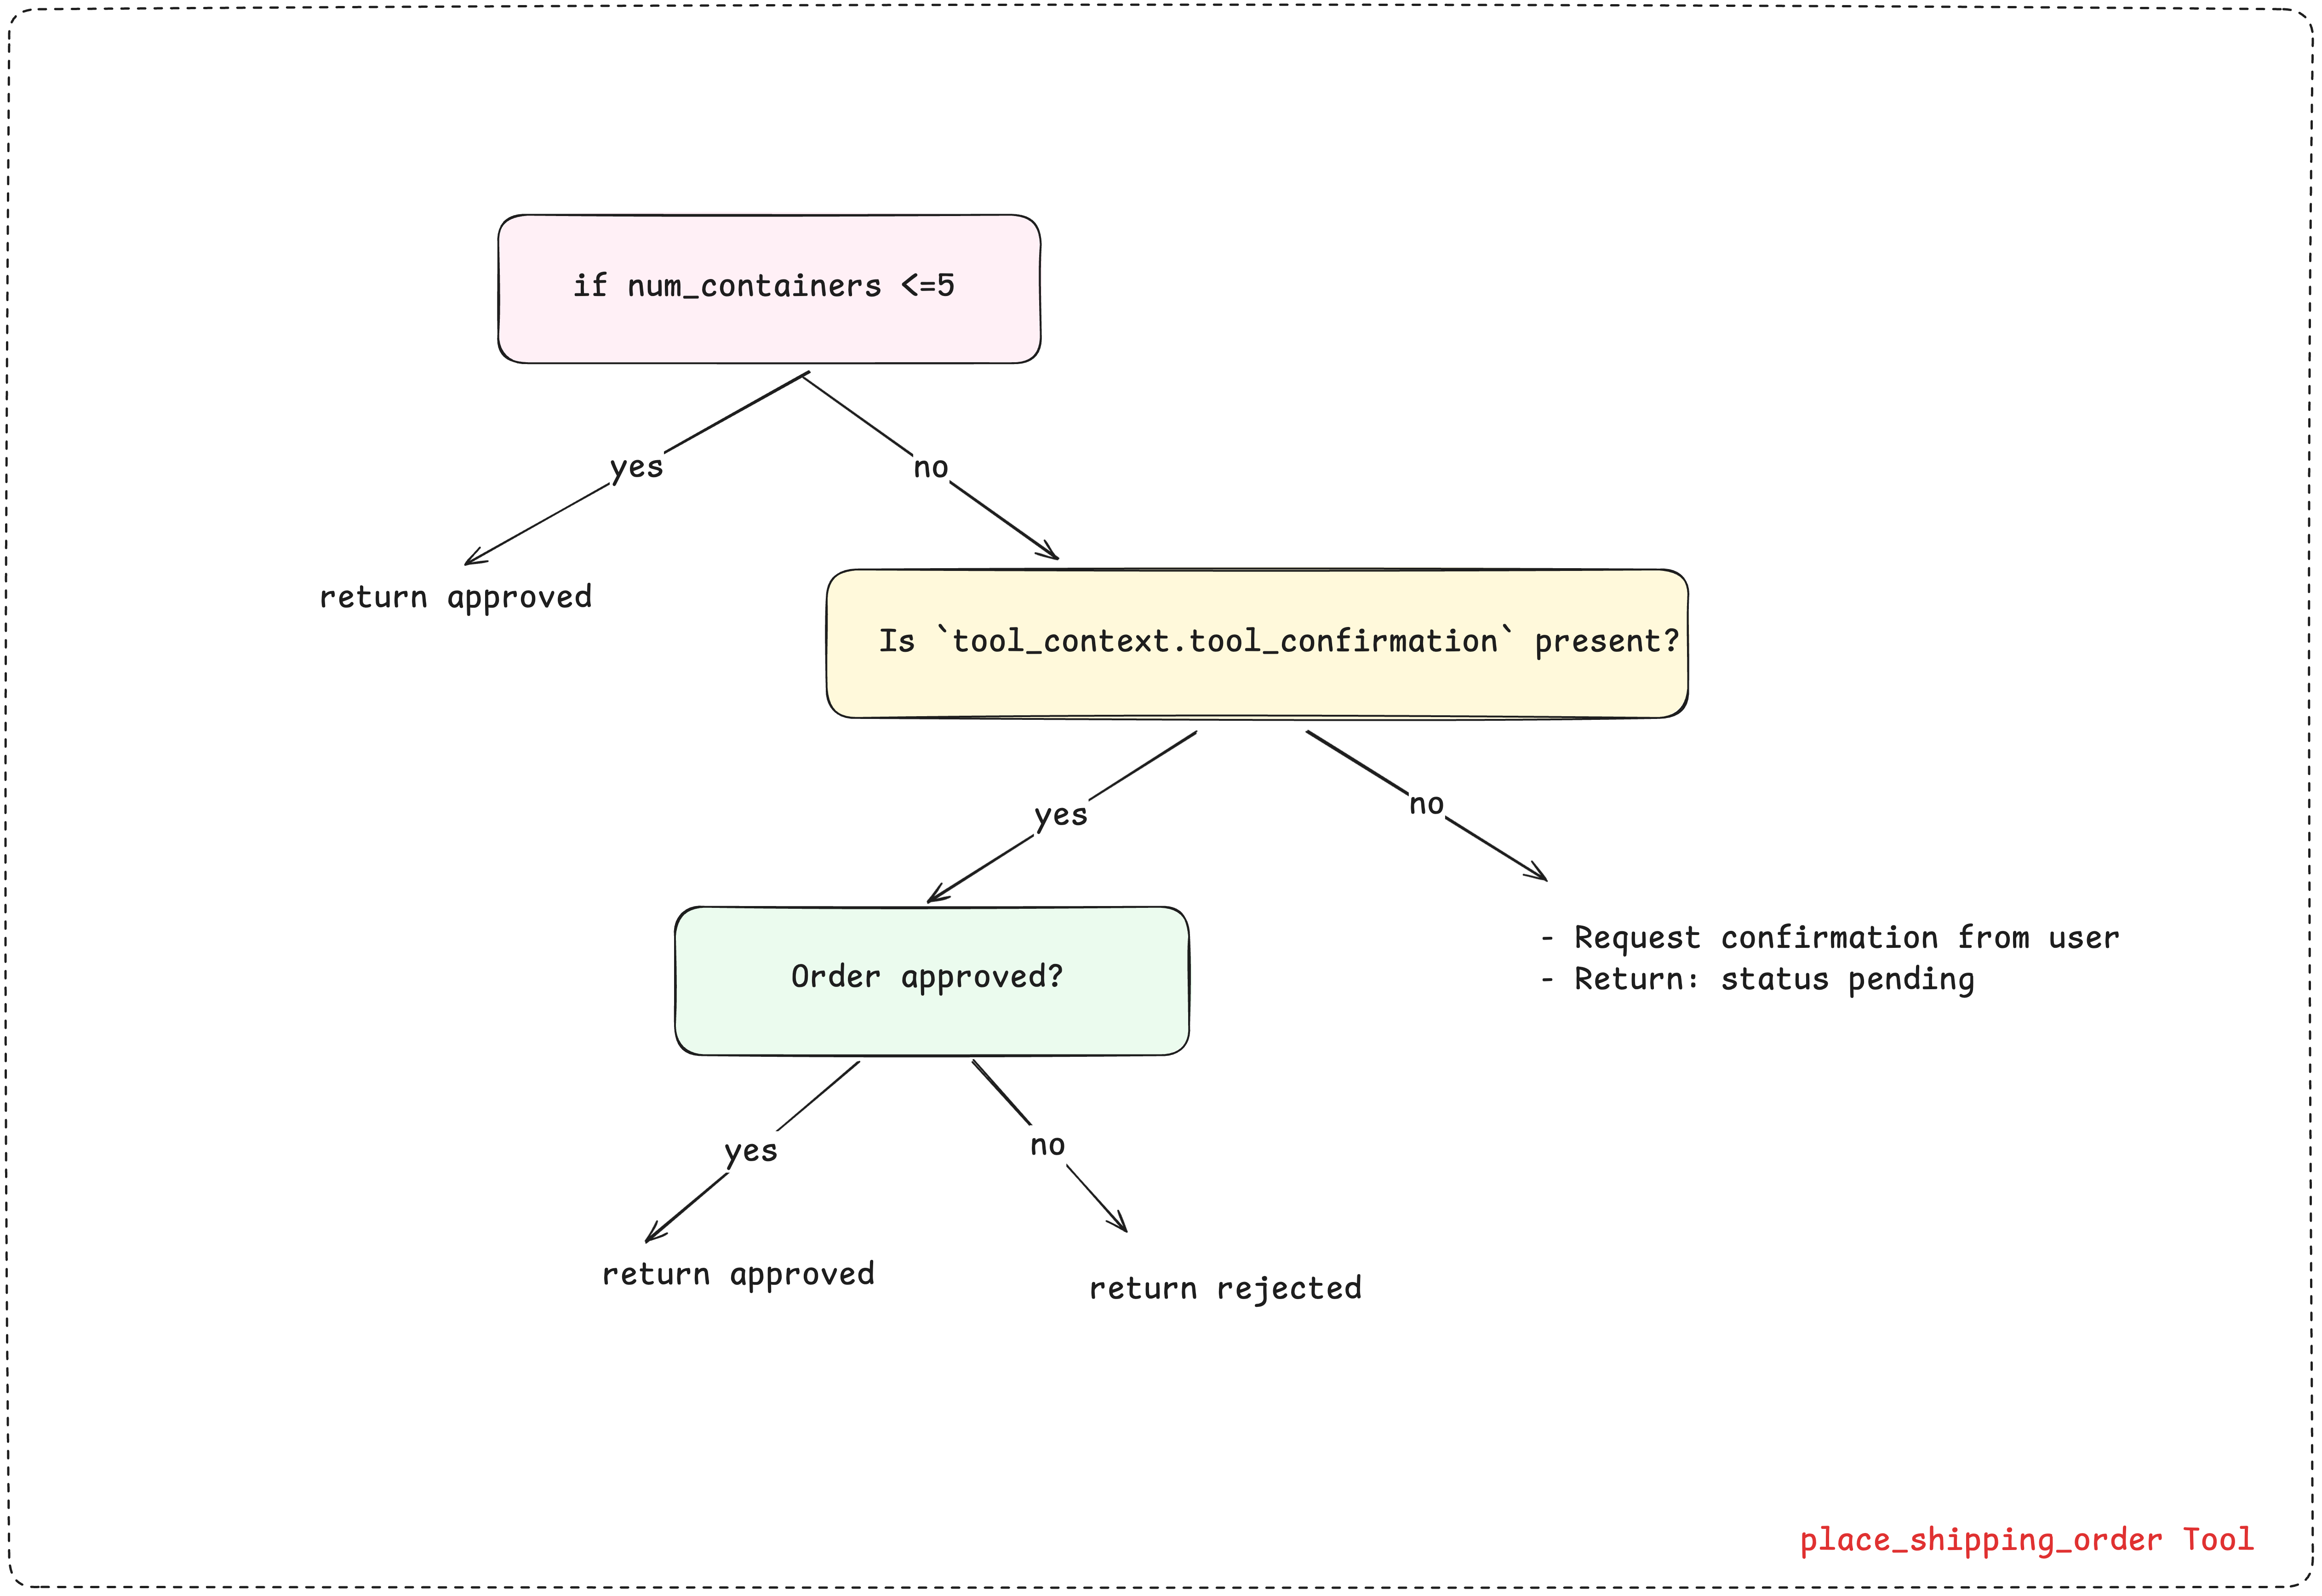

In [34]:
# Create shipping agent with pausable tool
shipping_agent = LlmAgent(
    name="shipping_agent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    instruction="""You are a shipping coordinator assistant.
  
  When users request to ship containers:
   1. Use the place_shipping_order tool with the number of containers and destination
   2. If the order status is 'pending', inform the user that approval is required
   3. After receiving the final result, provide a clear summary including:
      - Order status (approved/rejected)
      - Order ID (if available)
      - Number of containers and destination
   4. Keep responses concise but informative
  """,
    tools=[FunctionTool(func=place_shipping_order)],
)

print("✅ Shipping Agent created!")

✅ Shipping Agent created!


Wrap in `resumable App`

The problem: A regular LlmAgent is stateless - each call is independent with no memory of previous interactions. If a tool requests approval, the agent can't remember what it was doing.

The solution: Wrap your agent in an App with resumability enabled. The App adds a persistence layer that saves and restores state.

In [35]:
# Wrap the agent in a resumable app - THIS IS THE KEY FOR LONG-RUNNING OPERATIONS!
shipping_app = App(
    name="shipping_coordinator",
    root_agent=shipping_agent,
    resumability_config=ResumabilityConfig(is_resumable=True),
)

print("✅ Resumable app created!")

✅ Resumable app created!


/var/folders/c7/7248_v0s309_cglqg05jjzkc0000gn/T/ipykernel_14518/3673777575.py:5: UserWarning: [EXPERIMENTAL] ResumabilityConfig: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  resumability_config=ResumabilityConfig(is_resumable=True),


In [36]:
session_service = InMemorySessionService()

# Create runner with the resumable app
shipping_runner = Runner(
    app=shipping_app,  # Pass the app instead of the agent
    session_service=session_service,
)

print("✅ Runner created!")

✅ Runner created!


## Building the Workflow

### ⚠️ The Critical Part - Handling Events in Your Workflow

The agent won't automatically handle pause/resume. **Every long-running operation workflow requires you to:**

1. **Detect the pause:** Check if events contain `adk_request_confirmation`
2. **Get human decision:** In production, show UI and wait for user click. Here, we simulate it.
3. **Resume the agent:** Send the decision back with the saved `invocation_id`

### Key Technical Concepts

👉 **`events`** - ADK creates events as the agent executes. Tool calls, model responses, function results - all become events

👉 **`adk_request_confirmation` event** - This event is special - it signals "pause here!"
- Automatically created by ADK when your tool calls `request_confirmation()`
- Contains the `invocation_id`
- Your workflow must detect this event to know the agent paused

👉 **`invocation_id`** - Every call to `run_async()` gets a unique `invocation_id` (like "abc123")
- When a tool pauses, you save this ID
- When resuming, pass the same ID so ADK knows which execution to continue
- Without it, ADK would start a NEW execution instead of resuming the paused one

In [37]:
def check_for_approval(events):
    """Check if events contain an approval request.

    Returns:
        dict with approval details or None
    """
    for event in events:
        if event.content and event.content.parts:
            for part in event.content.parts:
                if (
                    part.function_call
                    and part.function_call.name == "adk_request_confirmation"
                ):
                    return {
                        "approval_id": part.function_call.id,
                        "invocation_id": event.invocation_id,
                    }
    return None

In [38]:
def print_agent_response(events):
    """Print agent's text responses from events."""
    for event in events:
        if event.content and event.content.parts:
            for part in event.content.parts:
                if part.text:
                    print(f"Agent > {part.text}")

In [39]:
def create_approval_response(approval_info, approved):
    """Create approval response message."""
    confirmation_response = types.FunctionResponse(
        id=approval_info["approval_id"],
        name="adk_request_confirmation",
        response={"confirmed": approved},
    )
    return types.Content(
        role="user", parts=[types.Part(function_response=confirmation_response)]
    )


print("✅ Helper functions defined")

✅ Helper functions defined


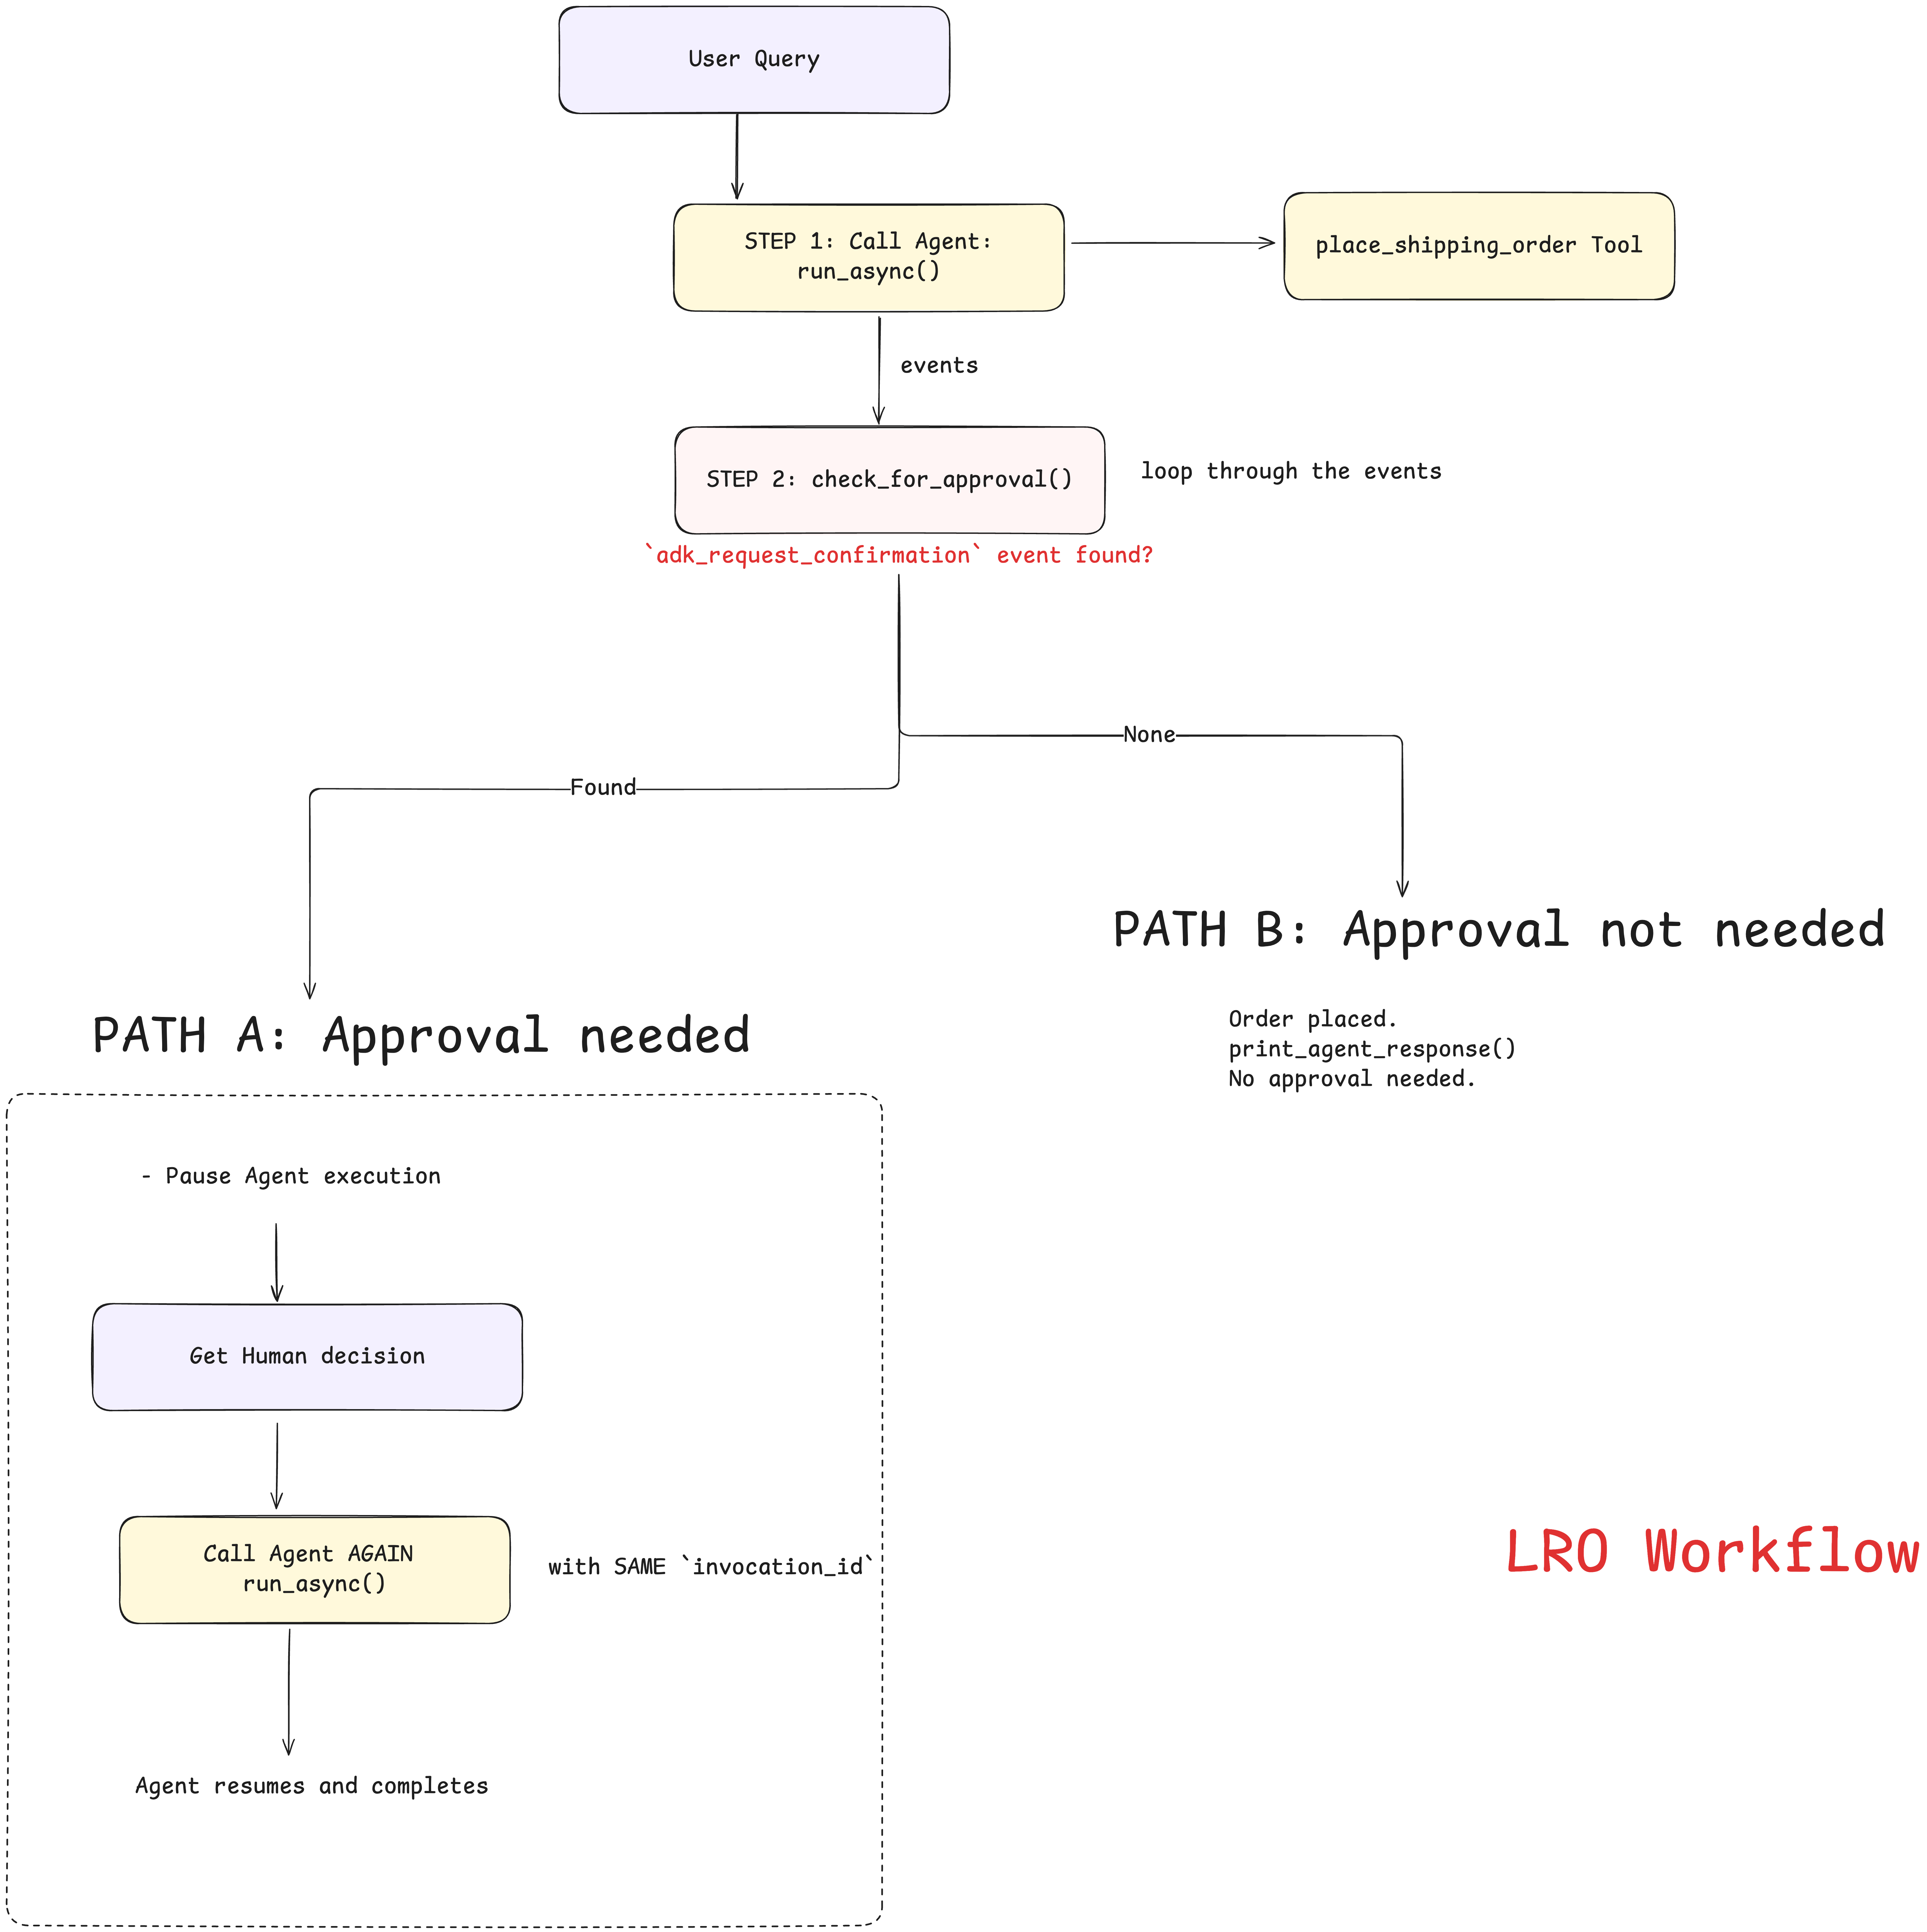

In [40]:
async def run_shipping_workflow(query: str, auto_approve: bool = True):
    """Runs a shipping workflow with approval handling.

    Args:
        query: User's shipping request
        auto_approve: Whether to auto-approve large orders (simulates human decision)
    """

    print(f"\n{'='*60}")
    print(f"User > {query}\n")

    # Generate unique session ID
    session_id = f"order_{uuid.uuid4().hex[:8]}"

    # Create session
    await session_service.create_session(
        app_name="shipping_coordinator", user_id="test_user", session_id=session_id
    )

    query_content = types.Content(role="user", parts=[types.Part(text=query)])
    events = []

    # -----------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------
    # STEP 1: Send initial request to the Agent. If num_containers > 5, the Agent returns the special `adk_request_confirmation` event
    async for event in shipping_runner.run_async(
        user_id="test_user", session_id=session_id, new_message=query_content
    ):
        events.append(event)

    # -----------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------
    # STEP 2: Loop through all the events generated and check if `adk_request_confirmation` is present.
    approval_info = check_for_approval(events)

    # -----------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------
    # STEP 3: If the event is present, it's a large order - HANDLE APPROVAL WORKFLOW
    if approval_info:
        print(f"⏸️  Pausing for approval...")
        print(f"🤔 Human Decision: {'APPROVE ✅' if auto_approve else 'REJECT ❌'}\n")

        # PATH A: Resume the agent by calling run_async() again with the approval decision
        async for event in shipping_runner.run_async(
            user_id="test_user",
            session_id=session_id,
            new_message=create_approval_response(
                approval_info, auto_approve
            ),  # Send human decision here
            invocation_id=approval_info[
                "invocation_id"
            ],  # Critical: same invocation_id tells ADK to RESUME
        ):
            if event.content and event.content.parts:
                for part in event.content.parts:
                    if part.text:
                        print(f"Agent > {part.text}")

    # -----------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------
    else:
        # PATH B: If the `adk_request_confirmation` is not present - no approval needed - order completed immediately.
        print_agent_response(events)

    print(f"{'='*60}\n")


print("✅ Workflow function ready")

✅ Workflow function ready


#### **Code breakdown**

**Step 1: Send initial request to the Agent**
- Call `run_async()` to start agent execution
- Collect all events in a list for inspection

**Step 2: Detect Pause**
- Call `check_for_approval(events)` to look for the special event: `adk_request_confirmation`
- Returns approval info (with `invocation_id`) if the special event is present; `None` if completed

**Step 3: Resume execution**

PATH A:
- If the approval info is present, at this point the Agent *pauses* for human input.
- Once the Human input is available, call the agent again using `run_async()` and pass in the Human input.
- **Critical:** Same `invocation_id` (tells ADK to RESUME, not restart)
- Display agent's final response after resuming

PATH B:
- If the approval info is not present, then approval is not needed and the agent completes execution.

In [43]:
# Demo 1: It's a small order. Agent receives auto-approved status from tool
await run_shipping_workflow("Ship 3 containers to Singapore")

# Demo 2: Workflow simulates human decision: APPROVE ✅
await run_shipping_workflow("Ship 10 containers to Rotterdam", auto_approve=True)

# Demo 3: Workflow simulates human decision: REJECT ❌
await run_shipping_workflow("Ship 8 containers to Los Angeles", auto_approve=False)


User > Ship 3 containers to Singapore

Agent > On its way! 3 containers are shipping to Singapore. The order ID is ORD-3-AUTO and it has been approved.


User > Ship 10 containers to Rotterdam



/Users/nicooteiza/.pyenv/versions/agents/lib/python3.11/site-packages/google/adk/tools/tool_context.py:92: UserWarning: [EXPERIMENTAL] ToolConfirmation: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  ToolConfirmation(
/Users/nicooteiza/.pyenv/versions/agents/lib/python3.11/site-packages/google/adk/agents/invocation_context.py:302: UserWarning: [EXPERIMENTAL] BaseAgentState: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  self.agent_states[event.author] = BaseAgentState()


⏸️  Pausing for approval...
🤔 Human Decision: APPROVE ✅

Agent > I have approved your request to ship 10 containers to Rotterdam. The order ID is ORD-10-HUMAN.


User > Ship 8 containers to Los Angeles

⏸️  Pausing for approval...
🤔 Human Decision: REJECT ❌

Agent > The order for 8 containers to Los Angeles has been rejected.

